Dataset address:

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

# Import packages

In [3]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import precision_score, recall_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

# Function definitions

In [4]:
def split_X_y(df, target): # Split the some full dataset into X and y (by column)
    y = df[target]
    X = df.drop(target, axis=1)
    return X, y


def concat_train_test(df_train, df_test): # Concatenate train and test set (by row)
    df_full = pd.concat([df_train, df_test], keys = ['train', 'test'])
    return df_full


def split_train_test(df_full):
    df_train = df_full.loc['train'].copy() # Split concatenated dataset into train, test (by row)
    df_test = df_full.loc['test'].copy()
    return df_train, df_test


def df_num_cat(df, features): # Split DataFrame features into numeric and categorical
    feature_num = [f for f in features if (df.dtypes[f] != 'object')]
    feature_cat = [f for f in features if (df.dtypes[f] == 'object')]
    return feature_num, feature_cat


def cal_null_percent(df): # Give percentage of null values in a dataframe, in descending order
    null_count = df.isnull().sum()
    null_percent = null_count / len(df)
    null_percent.sort_values(ascending=False, inplace=True)
    return null_percent


def df_columns_diagram(df, features:list, type): # Draw diagram of dataframe specific columns
    if len(features) == 0:
        print("The indices given are empty")
    elif len(features) == 1:
        fix, ax = plt.subplots(figsize = (6,4))
        for feature in features:
            df_ignore_nan = df.loc[~df[feature].isnull(), feature]

            if type == 'hist': # Histogram
                ax.hist(df_ignore_nan)
            elif type == 'bar': # Bar chart
                cat_counts = df_ignore_nan.value_counts()
                cats = cat_counts.index.to_list()
                counts = cat_counts.to_list()
                ax.bar(cats, counts)

            ax.set_title(feature + ' distribution')
            ax.set_xlabel(feature)
            ax.set_ylabel('Count')
    else: 
        fix, ax = plt.subplots(1, len(features), figsize = (6 * len(features),4))
        for feature in features:
            i = features.index(feature)
            df_ignore_nan = df.loc[~df[feature].isnull(), feature]

            if type == 'hist': # Histogram
                ax[i].hist(df_ignore_nan)
            elif type == 'bar': # Bar chart
                cat_counts = df_ignore_nan.value_counts()
                cats = cat_counts.index.to_list()
                counts = cat_counts.to_list()
                ax[i].bar(cats, counts)

            ax[i].set_title(feature + ' distribution')
            ax[i].set_xlabel(feature)
            ax[i].set_ylabel('Count')


def collinear_print(corr, threshold): # Print collinear relationship variables
    for i in range(len(corr)): # traverse rows
        for j in range(i+1, len(corr)): # traverse columns after column i
            if (abs(corr.iloc[i, j]) > threshold): # after drop some column, no need to traverse its correpsonding row afterwards
                print(f"{(corr.index.to_list()[i], corr.columns.to_list()[j])} has collinear relationship {corr.iloc[i, j]:.2f}")

# Import dataset

In [5]:
path_train = '/Users/yuwensun/Documents/编程/Kaggle/Kaggle_houseprice_prediction/train.csv'
path_test = '/Users/yuwensun/Documents/编程/Kaggle/Kaggle_houseprice_prediction/test.csv'
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

target = "SalePrice"
df_train[target] = np.log(df_train[target])


df_train, y_train = split_X_y(df_train, target)
# print(df_train.to_string())
df_full = concat_train_test(df_train, df_test)


#  Id
df_full.drop("Id", axis = 1, inplace=True)

unable_deal_features = ['MiscFeature', 'MiscVal']
df_full.drop(unable_deal_features, axis = 1, inplace=True)

# print(df_full.dtypes.to_string())
print(df_full.to_string())

            MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC  Fence  MoSold  YrSold SaleType SaleCondition
train 0             60       RL         65.0     8450   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl      CollgCr 

# Exploratory Data analysis

## Handling missing values

### 1. Make some specific column feature variables fillings

In [6]:
num_feature_with_mode = ['MasVnrArea', 'BsmtFinSF2', '2ndFlrSF', 'WoodDeckSF', 'OpenPorchSF', 
                         'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']
cat_feature_with_nan = ['Alley', 'FireplaceQu', 'GarageQual', 'PoolQC', 
                        'Fence', 'GarageCond', 'GarageFinish', 'GarageType', 'BsmtExposure', 
                        'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1']
disc_features = ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 
                 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
                 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold']

# fill missing values with mode
for feature in num_feature_with_mode+disc_features:
    df_full[feature].fillna(df_full[feature].mode()[0], inplace=True)

# Convert "NaN" into "None"
for feature in cat_feature_with_nan:
    df_full[feature].fillna("None", inplace=True)

### 2. Drop columns and rows by missing values

In [7]:
# Drop columns with over 'threshold' number of NaN values
threshold = 0.3
null_percent = cal_null_percent(df_full)
dropped = null_percent[null_percent > threshold].index.to_list() # Dropped column list. Over 30% of values are NaN values.
print(f"Dropped columns with over 30% NaN values are: {dropped}")
# print("---------------------------------------------------------")
df_full.drop(dropped, axis = 1, inplace=True)

# Drop rows whose column has little missing values between (0, 0.05)
df_train, df_test = split_train_test(df_full)
null_percent = cal_null_percent(df_full)
columns = null_percent[(null_percent > 0) & (null_percent < 0.03)].index.to_list()

df_train.dropna(subset = columns, axis = 0, inplace=True)
dropped_indices = df_full.loc['train'].index.difference(df_train.index).tolist()
print(f"Dropped indices are {dropped_indices}")
print(f"Features having missing values percentage between (0, 0.03) are: {columns}")
df_full = concat_train_test(df_train, df_test)
# df_full_dropped.shape

Dropped columns with over 30% NaN values are: ['MasVnrType']
Dropped indices are [1379]
Features having missing values percentage between (0, 0.03) are: ['MSZoning', 'Utilities', 'Functional', 'Exterior2nd', 'KitchenQual', 'SaleType', 'Electrical', 'Exterior1st', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF1', 'GarageArea']


### 3. Filling missing values of num (non-discrete and non_with_mode), cat

In [8]:
# Missed value columns
null_percent= cal_null_percent(df_full)
missvalue_features = null_percent[null_percent != 0].index.to_list()
print(f"Missed features: {missvalue_features}")


missvalue_features_num, missvalue_features_cat = df_num_cat(df_full, missvalue_features)
print(f"Numercial features are going to fill missing values: {missvalue_features_num}")
print(f"Categorical features are going to fill missing values: {missvalue_features_cat}")

Missed features: ['LotFrontage', 'MSZoning', 'Utilities', 'Functional', 'Exterior2nd', 'KitchenQual', 'SaleType', 'Exterior1st', 'TotalBsmtSF', 'BsmtUnfSF', 'GarageArea', 'BsmtFinSF1']
Numercial features are going to fill missing values: ['LotFrontage', 'TotalBsmtSF', 'BsmtUnfSF', 'GarageArea', 'BsmtFinSF1']
Categorical features are going to fill missing values: ['MSZoning', 'Utilities', 'Functional', 'Exterior2nd', 'KitchenQual', 'SaleType', 'Exterior1st']


#### - Numeric values (non-discrete and non_with_mode)

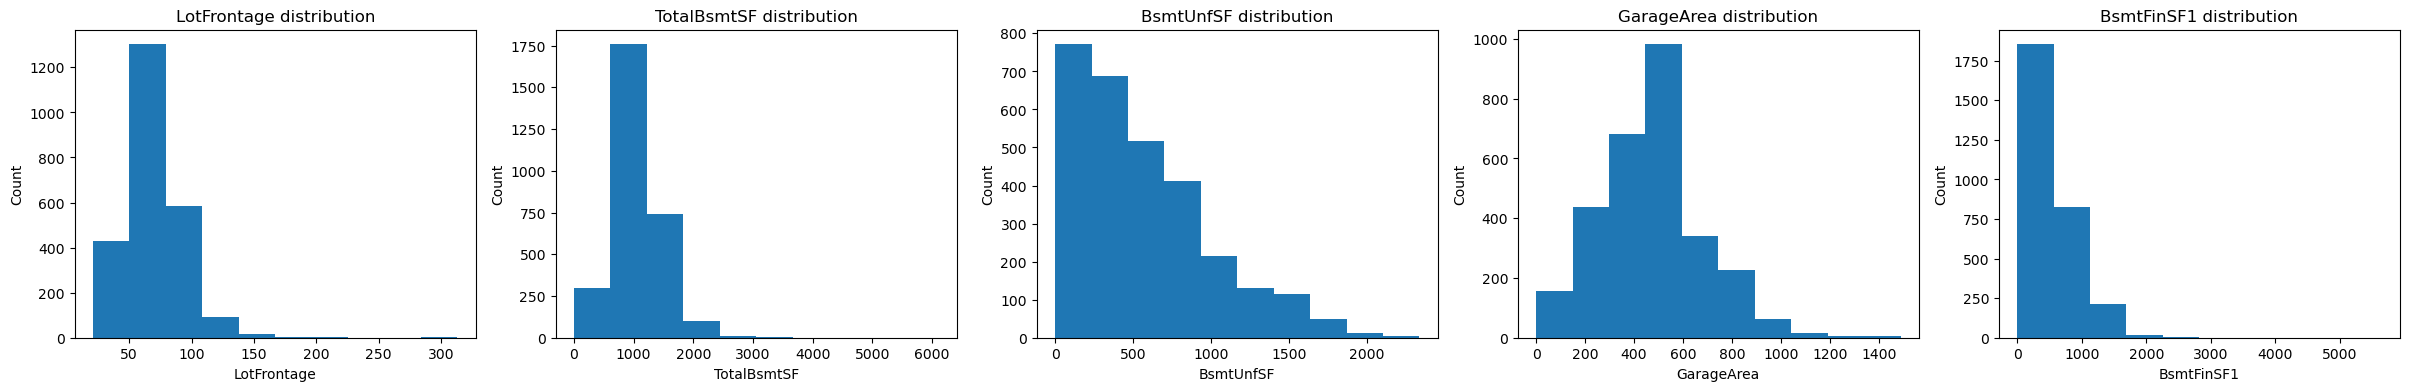

In [9]:
df_columns_diagram(df_full, missvalue_features_num, 'hist')
# df_train_X_dropped[missvalue_index_num].info()

#### - Filling outliers

In [10]:
lst = ['LotFrontage', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF']
outlier_values = [250, 1350, 2200, 1350]

for i in range(len(lst)):
    feature = lst[i]
    outlier_value = outlier_values[i]
    df_full.loc[(df_full[feature] > outlier_value), feature] = outlier_value

## After seeing all histograms, because it has some outliers, so we'd better to use median for missing values 
for index in missvalue_features_num:
    df_full[index].fillna(df_full[index].median(skipna = True), inplace = True)

#### - Categorical values

In [11]:
missvalue_features_cat
# df_full.columns

['MSZoning',
 'Utilities',
 'Functional',
 'Exterior2nd',
 'KitchenQual',
 'SaleType',
 'Exterior1st']

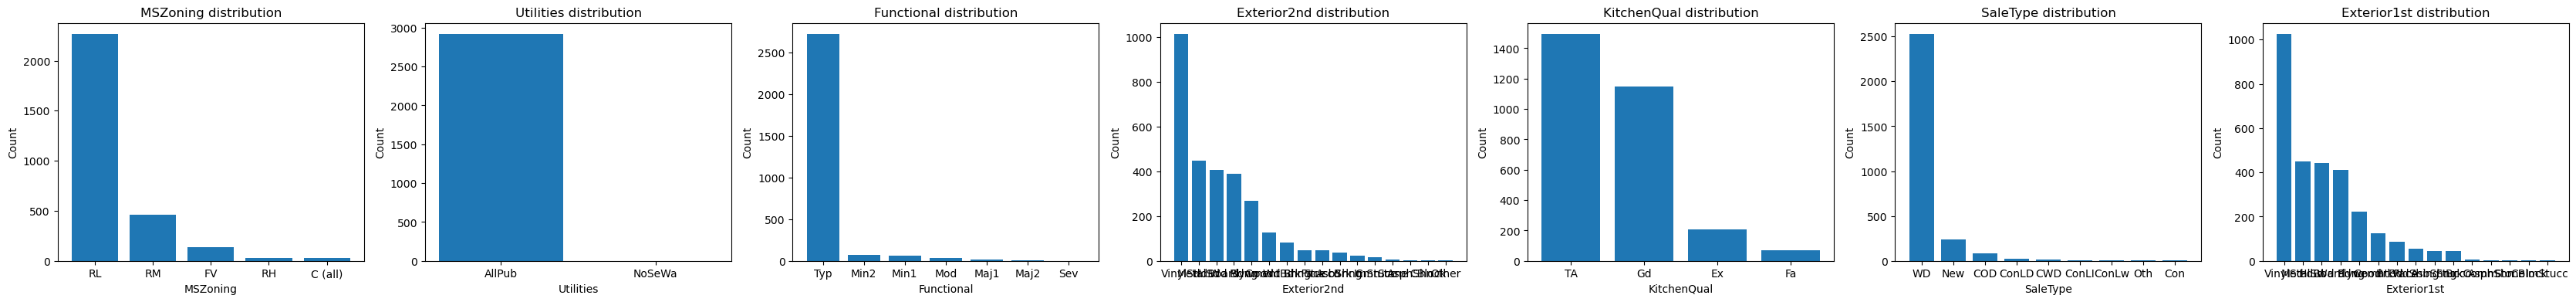

In [12]:
df_columns_diagram(df_full, missvalue_features_cat, 'bar')
# df_train_dropped.isnull().sum()[df_train_dropped.isnull().sum() != 0]

In [13]:
lst = ['Utilities', 'Functional', 'SaleType']
df_full.drop(lst, axis = 1, inplace=True)
for f in lst:
    missvalue_features_cat.remove(f)

# filling categorical missing values
for index in missvalue_features_cat:
    df_full[index].fillna(df_full[index].mode(dropna = True)[0], inplace = True)

# Data Preprocessing

## 1. Drop collinear columns

In [14]:
## Split into numeric and categorical data
num_features, cat_features = df_num_cat(df_full, df_full.dtypes.index.to_list())

print(f"Length: {len(num_features)}, {num_features}")
print(f"Length: {len(cat_features)}, {cat_features}")

Length: 35, ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MoSold', 'YrSold']
Length: 38, ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 

In [15]:
# Drop > threshold variables
df_train = df_full.loc['train'].copy()
corr = df_train[num_features].corr()
# sns.pairplot(df_train_dropped[num_features])
threshold = 0.6 
collinear_print(corr, 0.6)

# Drop collinear columns
drop_lst = ['GarageCars', 'GarageYrBlt', 'BsmtFullBath', '1stFlrSF', 'GrLivArea', 'HalfBath', 'TotRmsAbvGrd']
df_full.drop(drop_lst, axis=1, inplace=True)
print(df_full.to_string())

('OverallQual', 'GarageCars') has collinear relationship 0.60
('YearBuilt', 'GarageYrBlt') has collinear relationship 0.70
('BsmtFinSF1', 'BsmtFullBath') has collinear relationship 0.67
('TotalBsmtSF', '1stFlrSF') has collinear relationship 0.66
('2ndFlrSF', 'GrLivArea') has collinear relationship 0.69
('2ndFlrSF', 'HalfBath') has collinear relationship 0.61
('2ndFlrSF', 'TotRmsAbvGrd') has collinear relationship 0.62
('GrLivArea', 'FullBath') has collinear relationship 0.63
('GrLivArea', 'TotRmsAbvGrd') has collinear relationship 0.83
('BedroomAbvGr', 'TotRmsAbvGrd') has collinear relationship 0.68
('GarageCars', 'GarageArea') has collinear relationship 0.88
            MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure B

## 2. Encoding categorical variables & train-test split

In [16]:
num_features, cat_features = df_num_cat(df_full, df_full.dtypes.index.to_list())

print(f"Length: {len(num_features)}, Numeric features: {num_features}")
print(f"Length: {len(cat_features)}, Categorical features: {cat_features}")

Length: 28, Numeric features: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtHalfBath', 'FullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MoSold', 'YrSold']
Length: 38, Categorical features: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'SaleCondition']


In [17]:
# Train-test split 
X_dev, X_test = split_train_test(df_full)
y_dev = y_train.drop(dropped_indices)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, random_state=42)

In [18]:
# Encoding
for feature in cat_features:
    enc = OrdinalEncoder(categories = [X_train[feature].unique().tolist()], 
                         handle_unknown='use_encoded_value', unknown_value=-1)
    X_train[feature] = enc.fit_transform(X_train[feature].to_numpy().reshape(-1,1))
    X_val[feature] = enc.transform(X_val[feature].to_numpy().reshape(-1,1))
    X_test[feature] = enc.transform(X_test[feature].to_numpy().reshape(-1,1))

## 3. Scaling for numeric variables

In [19]:
print(f"Length: {len(disc_features)}, Discrete features: {sorted(disc_features)}")
print(f"Length: {len(num_features)}, Numeric features: {sorted(num_features)}")

Length: 17, Discrete features: ['BedroomAbvGr', 'BsmtFullBath', 'BsmtHalfBath', 'Fireplaces', 'FullBath', 'GarageCars', 'GarageYrBlt', 'HalfBath', 'KitchenAbvGr', 'MSSubClass', 'MoSold', 'OverallCond', 'OverallQual', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'YrSold']
Length: 28, Numeric features: ['2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea', 'ScreenPorch', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']


In [20]:
# For discrete and numerical values
for f in ['GarageCars', 'GarageYrBlt', 'BsmtFullBath','HalfBath', 'TotRmsAbvGrd']:
    disc_features.remove(f)

for f in disc_features:
    num_features.remove(f)

In [21]:
ss = StandardScaler()
# X_train[num_features] = ss.fit_transform(X_train[num_features])
# X_val[num_features] = ss.transform(X_val[num_features])
# X_test[num_features] = ss.transform(X_test[num_features])

X_train[num_features] = ss.fit_transform(X_train[num_features])
X_val[num_features] = ss.transform(X_val[num_features])
X_test[num_features] = ss.transform(X_test[num_features])

# Model selection

## 1. Random Forest

In [44]:
# Hyperparameter tunning
rf = RandomForestRegressor(random_state=42)
hyper = {'n_estimators': np.arange(40, 200, 10),
         'max_depth': np.arange(5, 20)}

rfcv = GridSearchCV(rf, hyper, cv = 10)
rfcv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                         'n_estimators': array([ 40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160,
       170, 180, 190])})

In [45]:
rf_optimal = RandomForestRegressor(n_estimators = rfcv.best_params_['n_estimators'], 
                           max_depth = rfcv.best_params_['max_depth'], 
                           random_state=42)
rf_optimal.fit(X_train, y_train)
y_pred = rf_optimal.predict(X_val)
# rf.score(X_val, y_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print("RandomForest RMSE:", rmse)

RandomForest RMSE: 0.16023116121443745


## 2. XGBoost

In [22]:
xgb_model = xgb.XGBRegressor(random_state = 42)
hyper = {'learning_rate': np.arange(0, 1, 0.04),
         'max_depth': np.arange(5, 20)}

xgb_modelcv = GridSearchCV(xgb_model, hyper, cv = 10)
xgb_modelcv.fit(X_train, y_train)

In [53]:
xgbmodel_optimal = xgb.XGBRegressor(learning_rate = xgb_modelcv.best_params_['learning_rate'], 
                           max_depth = xgb_modelcv.best_params_['max_depth'], 
                           random_state=42)
xgbmodel_optimal.fit(X_train, y_train)
y_pred = xgbmodel_optimal.predict(X_val)
# rf.score(X_val, y_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print("XGBoost RMSE:", rmse)

XGBoost RMSE: 0.1504414594117122


## 3. Lasso regression

In [54]:
ls = Lasso(random_state=42)
hyper = {'alpha': np.arange(0.01, 2, 0.01)}

lscv = GridSearchCV(ls, hyper, cv = 10)
lscv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=Lasso(random_state=42),
             param_grid={'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0...
       1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31, 1.32,
       1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42, 1.43,
       1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5 , 1.51, 1.52, 1.53, 1.54,
       1.55, 1.56, 1.57, 1.58, 1.59, 1.6 , 1.61, 1.62, 1.63, 1.64, 1.65,
       1.66, 1.67, 1.68, 1.69, 1.7 , 1.71, 1.72, 1.73, 1.74, 1.75, 1.76,
       1.77, 1.78, 1.79, 1.8 , 1.81, 1.82, 1.83, 1.84, 1.85, 1.86, 1.87,
       1.88, 1.89, 1.9 , 1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98,
       1.99])})

In [55]:
ls_optimal = Lasso(alpha = lscv.best_params_['alpha'],
                    random_state=42)
ls_optimal.fit(X_train, y_train)
y_pred = ls_optimal.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print("Lasso regression RMSE:", rmse)

Lasso regression RMSE: 0.14756446246697308


## 4. Ridge regression

In [56]:
ridge = Ridge(random_state=42)
hyper = {'alpha': np.arange(0.01, 2, 0.01)}

ridgecv = GridSearchCV(ridge, hyper, cv = 10)
ridgecv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=Ridge(random_state=42),
             param_grid={'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0...
       1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31, 1.32,
       1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42, 1.43,
       1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5 , 1.51, 1.52, 1.53, 1.54,
       1.55, 1.56, 1.57, 1.58, 1.59, 1.6 , 1.61, 1.62, 1.63, 1.64, 1.65,
       1.66, 1.67, 1.68, 1.69, 1.7 , 1.71, 1.72, 1.73, 1.74, 1.75, 1.76,
       1.77, 1.78, 1.79, 1.8 , 1.81, 1.82, 1.83, 1.84, 1.85, 1.86, 1.87,
       1.88, 1.89, 1.9 , 1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98,
       1.99])})

In [57]:
ridge_optimal = Ridge(alpha = ridgecv.best_params_['alpha'],
                    random_state=42)
ridge_optimal.fit(X_train, y_train)
y_pred = ridge_optimal.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print("Ridge regression RMSE:", rmse)

Ridge regression RMSE: 0.14564072811110218


## 5. Elastic-net regression

In [62]:
enet = ElasticNet(random_state=42)
hyper = {'alpha': np.arange(0.01, 2, 0.01),
         'l1_ratio': np.arange(0.01, 1, 0.01)}

enetcv = GridSearchCV(enet, hyper, cv = 10)
enetcv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=ElasticNet(random_state=42),
             param_grid={'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0...
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])})

In [63]:
enet_optimal = Ridge(alpha = enetcv.best_params_['alpha'],
                    random_state=42)
enet_optimal.fit(X_train, y_train)
y_pred = enet_optimal.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print("ElasticNet regression RMSE:", rmse)

ElasticNet regression RMSE: 0.14621471007492481


# Feature selection

In [ ]:
# Feature importance
X = X_train.columns.to_list()
importance = rf.feature_importances_

sorted_idx = importance.argsort()[::-1]
X_sorted = [X[i] for i in sorted_idx]
importance_sorted = [importance[i] for i in sorted_idx]

fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(X_sorted, importance_sorted)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
features_selected = X_sorted[0:45]
X_train = X_train[features_selected]
X_val = X_val[features_selected]
X_test = X_test[features_selected]

rf = RandomForestRegressor(random_state=42)
hyper = {'n_estimators': np.arange(40, 200, 5),
         'max_depth': np.arange(5,20, 5)}

rfcv = GridSearchCV(rf, hyper, cv = 10)
rfcv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': array([ 5, 10, 15]),
                         'n_estimators': array([ 40,  45,  50,  55,  60,  65,  70,  75,  80,  85,  90,  95, 100,
       105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165,
       170, 175, 180, 185, 190, 195])})

In [ ]:
rfcv.best_estimator_

RandomForestRegressor(max_depth=15, n_estimators=195, random_state=42)

In [ ]:
rf = RandomForestRegressor(n_estimators=195, max_depth=15, random_state=42)
rf.fit(X_train[features_selected], y_train)
X_val = X_val[features_selected]
y_pred = rf.predict(X_val)
# rf.score(X_val, y_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print("RMSE:", rmse)

RMSE: 0.15028939610032158


# Submission of output

## Output the results

In [64]:
# Prediction
path_test = '/Users/yuwensun/Documents/编程/Kaggle/Kaggle_houseprice_prediction/test.csv'
test_Id = pd.read_csv(path_test)['Id'].to_list()
y_test = np.exp(ridge_optimal.predict(X_test))

output = pd.DataFrame({'Id': test_Id, 'SalePrice': y_test})
output

Id      SalePrice
0     1461  126377.946618
1     1462  162081.304882
2     1463  178146.333861
3     1464  199829.967209
4     1465  184190.220256
...    ...            ...
1454  2915  102024.355850
1455  2916  103584.495865
1456  2917  190033.037274
1457  2918  108632.575171
1458  2919  226046.441824

[1459 rows x 2 columns]

## Save submission

In [65]:
save_path = '/Users/yuwensun/Documents/编程/Kaggle/Kaggle_houseprice_prediction/submission.csv'
output.to_csv(save_path, index=False)